In [102]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [103]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [104]:
pwd

'/content/gdrive/My Drive/kaggle'

[http://www.peterjbentley.com/heartchallenge/](https://)

In [105]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [106]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


Populating the interactive namespace from numpy and matplotlib


In [ ]:
!kaggle datasets download -d kinguistics/heartbeat-sounds

heartbeat-sounds.zip: Skipping, found more recently modified local copy (use --force to force download)


In [107]:
ls

COVID-CT-MetaInfo.xlsx  Iris.csv     LUS_covid.csv  set_a.csv         set_b.csv
database.sqlite         Iris.gsheet  Maldata.csv    set_a_timing.csv
heartbeat-sounds.zip    kaggle.json  set_a/         set_b/


In [ ]:
!unzip heartbeat-sounds.zip

Archive:  heartbeat-sounds.zip
replace set_a.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: set_a.csv               
  inflating: set_a/Aunlabelledtest__201012172010.wav  
  inflating: set_a/Aunlabelledtest__201101051105.wav  
  inflating: set_a/Aunlabelledtest__201101061552.wav  
  inflating: set_a/Aunlabelledtest__201101091156.wav  
  inflating: set_a/Aunlabelledtest__201101110659.wav  
  inflating: set_a/Aunlabelledtest__201101152256.wav  
  inflating: set_a/Aunlabelledtest__201101220549.wav  
  inflating: set_a/Aunlabelledtest__201101241434.wav  
  inflating: set_a/Aunlabelledtest__201102081033.wav  
  inflating: set_a/Aunlabelledtest__201102081045.wav  
  inflating: set_a/Aunlabelledtest__201102200848.wav  
  inflating: set_a/Aunlabelledtest__201103011036.wav  
  inflating: set_a/Aunlabelledtest__201103140236.wav  
  inflating: set_a/Aunlabelledtest__201103170122.wav  
  inflating: set_a/Aunlabelledtest__201103200518.wav  
  inflating: set_a/Aunlabelledtest__20110320131

In [108]:
# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.4.1
keras version:  2.4.3


In [109]:
# parent folder of sound files
INPUT_DIR="/content/gdrive/My Drive/kaggle"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12   

In [ ]:
# check what is inside each directory and content
!pwd
!ls -all /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle
ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/kaggle': No such file or directory


In [111]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [112]:
set_a_timing=pd.read_csv(INPUT_DIR+"/set_a_timing.csv")
set_a_timing.head()

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992


In [113]:
set_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
set_b.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [114]:
#merge both set-a and set-b
frames = [set_a, set_b]
train_ab=pd.concat(frames)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_b/Bunlabelledtest_220_1308250132896_A.wav,normal,noisynormal
freq,656,1,351,120


In [115]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


Min samples per category =  19
Max samples per category =  351


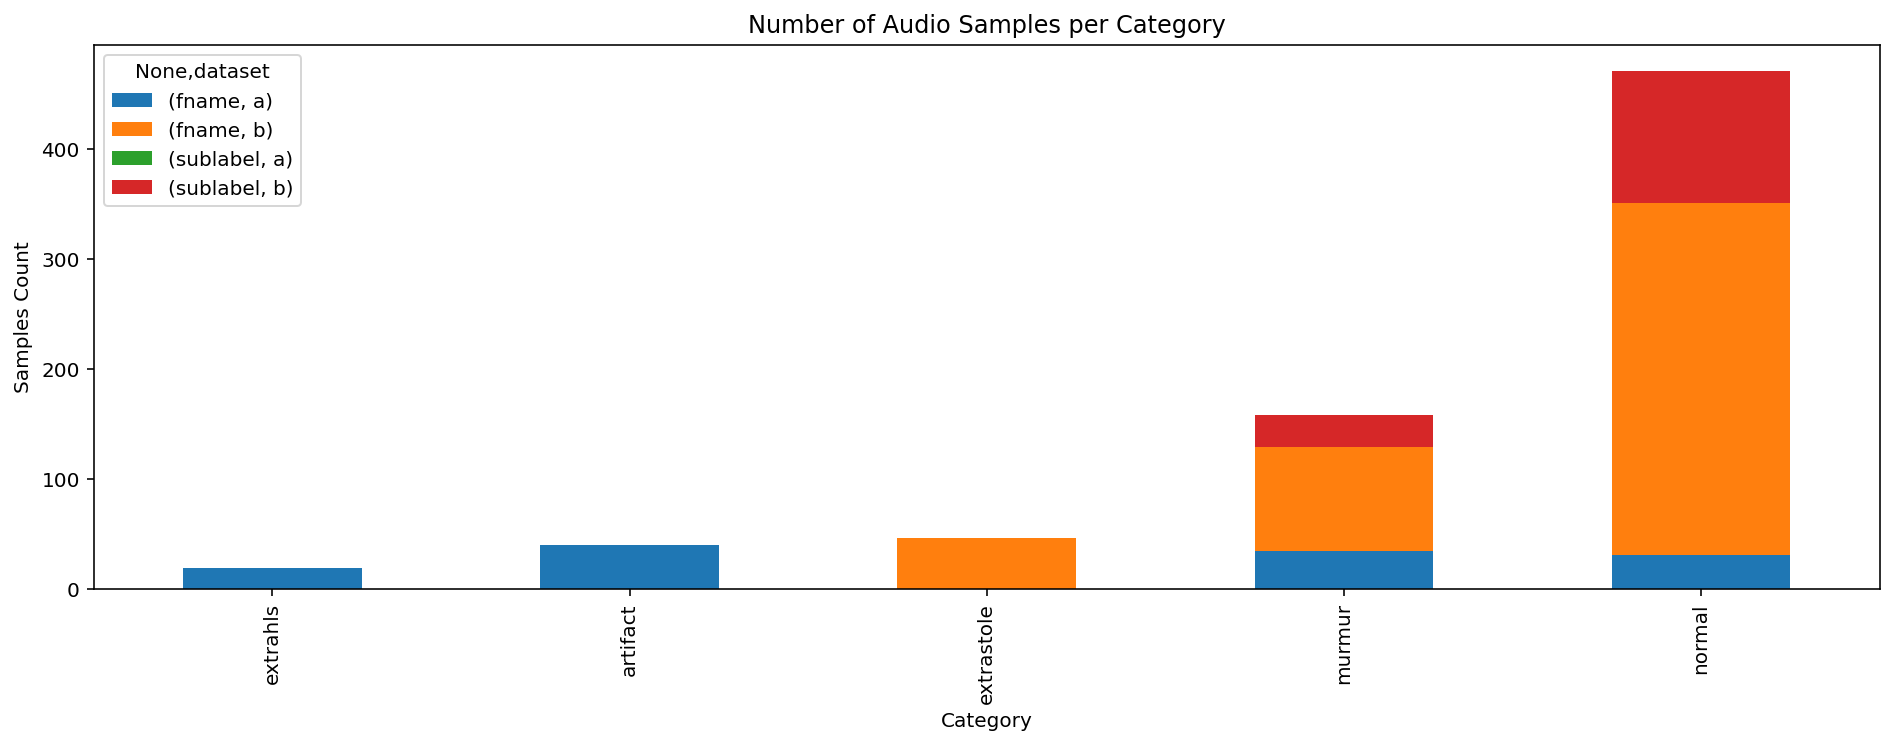

In [116]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))


In [117]:
print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

Minimum samples per category =  19
Maximum samples per category =  351


In [118]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [119]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file) 

In [120]:
# Load use wave 
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [121]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


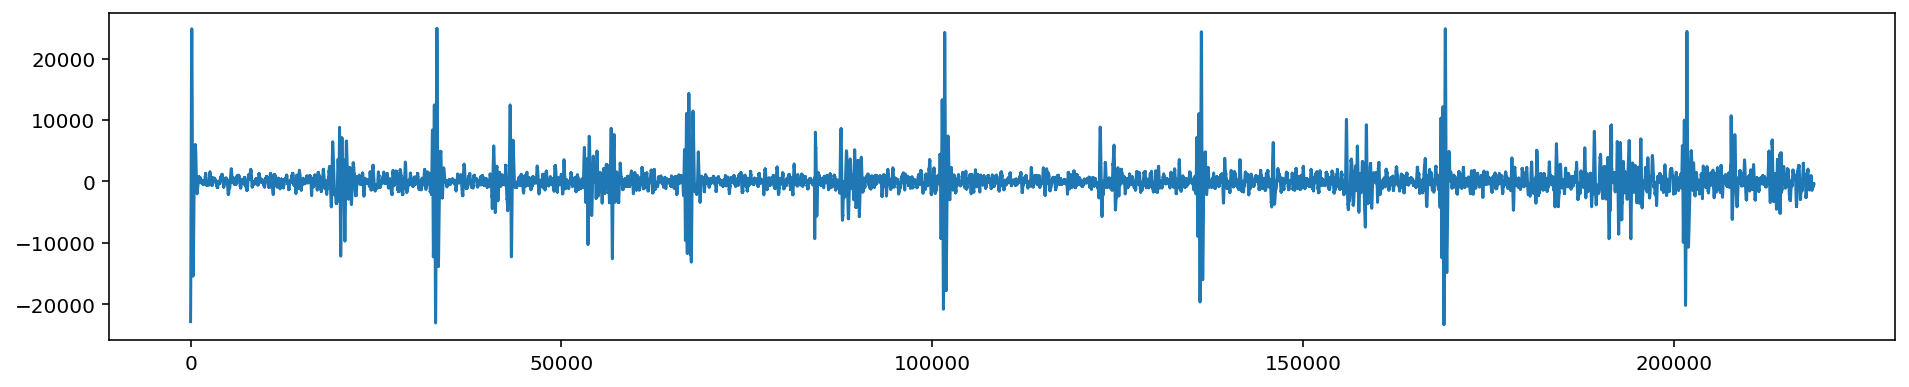

In [122]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [123]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-2.4546130e+02 -2.9111914e+02 -4.0244803e+02 ... -3.6787161e+02
  -3.7070840e+02 -3.7246997e+02]
 [ 8.8640701e+01  9.8866135e+01  1.3325652e+02 ...  1.5128104e+02
   1.5726184e+02  1.5245227e+02]
 [ 1.0397891e+02  8.5698502e+01  2.3744316e+01 ...  2.9162670e+01
   2.9376698e+01  3.7446297e+01]
 ...
 [-1.3324329e+01 -8.1943016e+00 -1.1898929e+00 ...  9.6601009e-02
   6.2489367e-01  1.1953502e+00]
 [ 3.1632262e-01 -4.9924183e-01 -1.5885925e-01 ...  2.2277083e+00
  -2.1508545e-01  4.8489895e+00]
 [ 3.3431330e+00 -9.8901147e-01 -2.7710872e+00 ...  2.6507771e+00
  -1.3875097e+00  1.8579394e+00]]


In [124]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.57587302,
       3.80807256, 3.85451247, 4.13315193, 4.36535147, 4.59755102,
       4.73687075, 4.85297052])

In [125]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

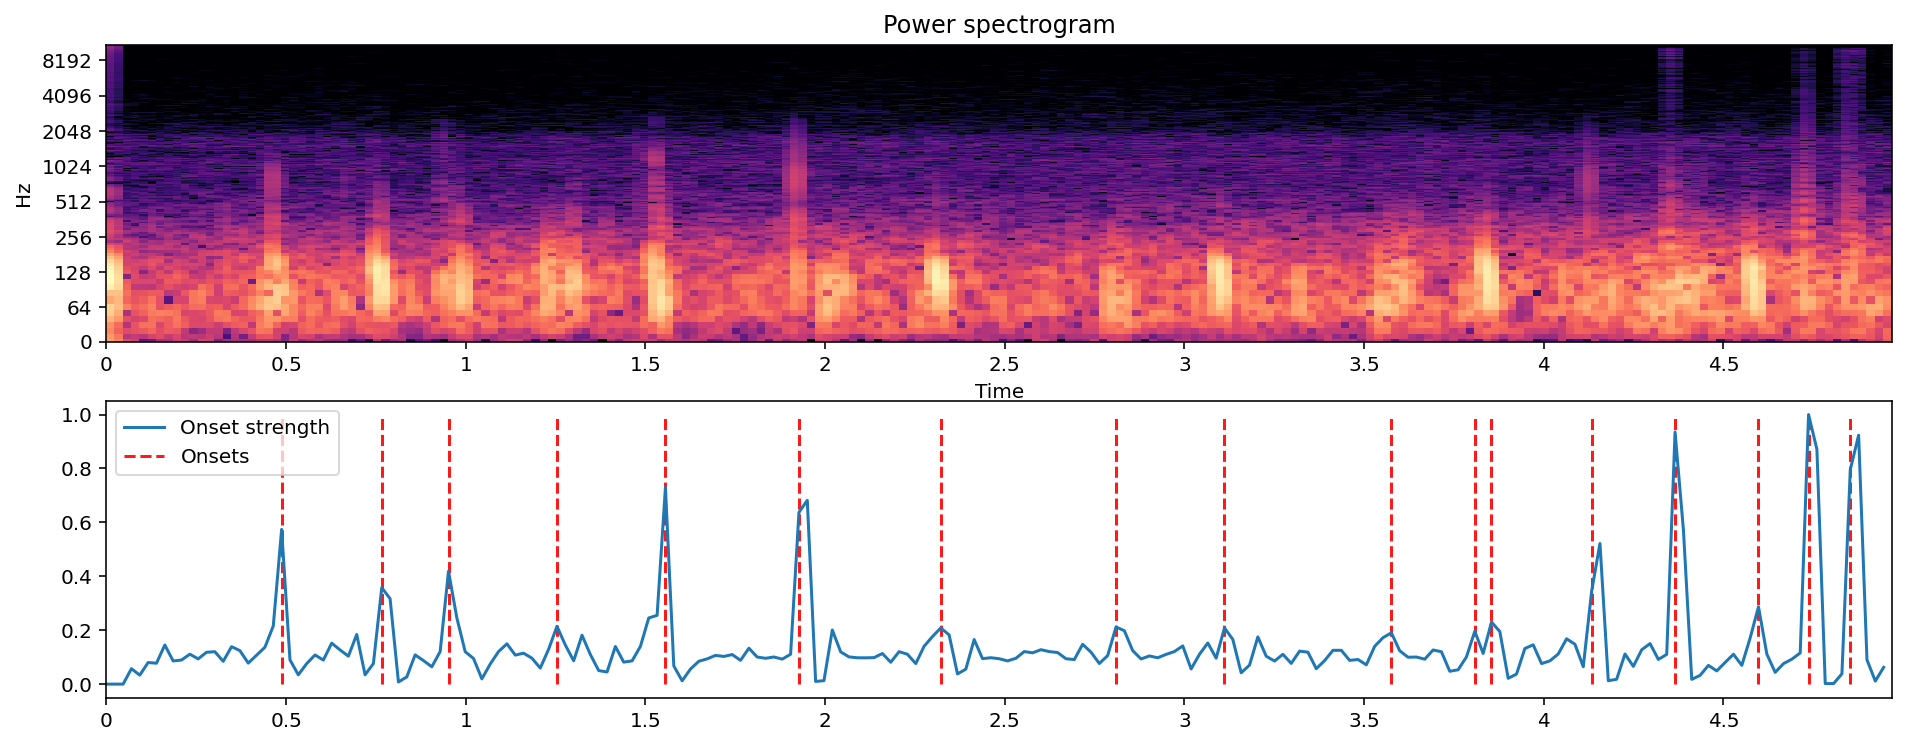

In [126]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

In [156]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os,fnmatch

In [157]:
music="/content/gdrive/My Drive/kaggle/set_a/"
import librosa
import IPython.display as ipd
x,sr=librosa.load(music+"normal__201106221418.wav",duration=5)
ipd.Audio(x,rate=sr)

In [158]:
def ses_df(music_folders,kolonlar,tür_liste):
    liste=[]
    adim=0
    for folder in music_folders:
        for tür in tür_liste:
            dosyalar=fnmatch.filter(os.listdir(folder),tür)
            label=tür.split("*")[0]
            for dosya in dosyalar:
                x,sr=librosa.load(folder+dosya,duration=5,res_type='kaiser_fast')
                liste.append([np.mean(x) for x in librosa.feature.mfcc(x,sr=sr)])
                liste[adim].append(sum(librosa.zero_crossings(x)))
                liste[adim].append(np.mean(librosa.feature.spectral_centroid(x)))
                liste[adim].append(np.mean(librosa.feature.spectral_rolloff(x,sr=sr)))
                liste[adim].append(np.mean(librosa.feature.chroma_stft(x,sr=sr)))
                liste[adim].append(label)
                liste[adim].append(dosya)
                adim+=1
    return pd.DataFrame(liste,columns=kolonlar)

In [160]:
music_folders=["/content/gdrive/My Drive/kaggle/set_a/","/content/gdrive/My Drive/kaggle/set_b/"]
kolonlar=["mfkk"+str(i) for i in range(20)]
for isim in ["zero","centroid","rolloff","chroma","tür","dosya"]:
    kolonlar.append(isim)
tür_liste=["normal*.wav","artifact*.wav","murmur*.wav"]
music_df=ses_df(music_folders,kolonlar,tür_liste)

In [161]:
print(music_df.shape)
music_df.head()

(520, 26)


,mfkk0,mfkk1,mfkk2,mfkk3,mfkk4,mfkk5,mfkk6,mfkk7,mfkk8,mfkk9,mfkk10,mfkk11,mfkk12,mfkk13,mfkk14,mfkk15,mfkk16,mfkk17,mfkk18,mfkk19,zero,centroid,rolloff,chroma,tür,dosya
0,-504.037964,76.997124,-1.585262,34.563679,0.663375,23.808498,-3.102400,16.335907,-6.465251,11.320951,-7.647814,6.636135,-9.072886,2.825627,-9.941510,0.288859,-9.759557,-1.204180,-8.794813,-2.499642,22856,2543.690892,5384.696452,0.671670,normal,normal__201101070538.wav
1,-369.186737,91.602287,8.740098,45.028107,21.458738,27.615288,17.346260,19.143579,14.277477,20.668922,16.914289,12.288245,7.015624,10.820690,10.951164,7.448577,6.130361,5.795323,4.890225,3.060663,1486,900.728824,2140.559896,0.750158,normal,normal__201101151127.wav
2,-379.535004,118.246223,8.529406,19.718822,-3.027937,20.717894,0.050543,13.745317,-3.446706,18.079884,-0.657232,9.645381,-10.000034,8.520800,-7.436246,7.344613,-11.210546,5.854636,-9.596211,7.771472,10657,1927.470131,4725.541178,0.635878,normal,normal__201102081152.wav
3,-342.682220,133.837189,-11.243758,21.353348,-0.145609,29.179508,-5.019008,13.736671,-3.991349,15.423252,-8.008150,3.427294,-4.359004,13.799347,0.412823,5.838560,-1.418861,6.903131,-1.007653,1.195708,7681,1503.253101,3166.028849,0.637516,normal,normal__201102081321.wav
4,-549.604980,73.100739,-1.697143,28.962118,-0.544705,18.543926,-1.803224,15.123065,-6.083784,9.622066,-7.777274,6.096657,-8.359727,3.545679,-10.037402,-0.315625,-8.850921,-0.998493,-7.304602,-1.575300,25069,2680.044197,5603.118896,0.677684,normal,normal__201102201230.wav


In [162]:
music_df["tür"].value_counts()

normal      351
murmur      129
artifact     40
Name: tür, dtype: int64

In [163]:
X=music_df.iloc[:,0:24]
X.head()

,mfkk0,mfkk1,mfkk2,mfkk3,mfkk4,mfkk5,mfkk6,mfkk7,mfkk8,mfkk9,mfkk10,mfkk11,mfkk12,mfkk13,mfkk14,mfkk15,mfkk16,mfkk17,mfkk18,mfkk19,zero,centroid,rolloff,chroma
0,-504.037964,76.997124,-1.585262,34.563679,0.663375,23.808498,-3.102400,16.335907,-6.465251,11.320951,-7.647814,6.636135,-9.072886,2.825627,-9.941510,0.288859,-9.759557,-1.204180,-8.794813,-2.499642,22856,2543.690892,5384.696452,0.671670
1,-369.186737,91.602287,8.740098,45.028107,21.458738,27.615288,17.346260,19.143579,14.277477,20.668922,16.914289,12.288245,7.015624,10.820690,10.951164,7.448577,6.130361,5.795323,4.890225,3.060663,1486,900.728824,2140.559896,0.750158
2,-379.535004,118.246223,8.529406,19.718822,-3.027937,20.717894,0.050543,13.745317,-3.446706,18.079884,-0.657232,9.645381,-10.000034,8.520800,-7.436246,7.344613,-11.210546,5.854636,-9.596211,7.771472,10657,1927.470131,4725.541178,0.635878
3,-342.682220,133.837189,-11.243758,21.353348,-0.145609,29.179508,-5.019008,13.736671,-3.991349,15.423252,-8.008150,3.427294,-4.359004,13.799347,0.412823,5.838560,-1.418861,6.903131,-1.007653,1.195708,7681,1503.253101,3166.028849,0.637516
4,-549.604980,73.100739,-1.697143,28.962118,-0.544705,18.543926,-1.803224,15.123065,-6.083784,9.622066,-7.777274,6.096657,-8.359727,3.545679,-10.037402,-0.315625,-8.850921,-0.998493,-7.304602,-1.575300,25069,2680.044197,5603.118896,0.677684


In [164]:
y=music_df["tür"]
y.head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: tür, dtype: object

In [165]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder().fit(y)
y=le.transform(y)
y[10:40]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [166]:
from sklearn.model_selection import train_test_split,GridSearchCV
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=31)
print("X Train: ",len(X_train),"\n","X Test: ",len(X_test),sep="")

X Train: 390
X Test: 130


In [167]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(max_depth= 8,
 max_features= 5,
 min_samples_split=5,
 n_estimators=500).fit(X_train,y_train)
forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [168]:
from sklearn.metrics import accuracy_score
y_pred=forest.predict(X_test)
accuracy_score(y_test,y_pred)

0.8692307692307693

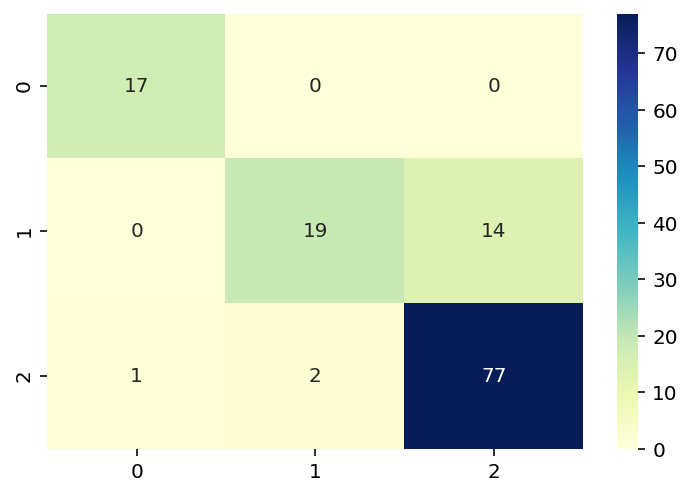

In [169]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu")